In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install easyocr
!pip install -U scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu118


In [3]:
from PIL import Image
import easyocr
from IPython.display import display
import numpy as np
from collections import defaultdict
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
reader = easyocr.Reader(['en', 'da'])

In [5]:
def readText(img):
    allow_list = "abcdefghijklmnopqrstuvxyzABCDEFGHIJKLMNOPQRSTUVXYZ1234567890:. "
    return reader.readtext(
        np.array(img), 
        detail=1,
        allowlist=allow_list, 
        decoder="greedy", 
        width_ths=0.35) # Fine tuned. "Hoestrup" name is long and clashes with next column. This value causes the text boxes to be split

In [6]:
heat1_path = "./2023-10-11/Heat1-cropped.png"
heat1_img = Image.open(heat1_path)
heat2_path = "./2023-10-11/Heat2-cropped.PNG"
heat2_img = Image.open(heat2_path)
heat3_path = "./2023-10-11/Heat3-cropped.PNG"
heat3_img = Image.open(heat3_path)
heat4_path = "./2023-10-11/Heat4-cropped.PNG"
heat4_img = Image.open(heat4_path)


In [7]:
heat1_boxes = readText(heat1_img)
heat2_boxes = readText(heat2_img)
heat3_boxes = readText(heat3_img)
heat4_boxes = readText(heat4_img)

In [8]:
heat1_boxes

[([[0, 0], [102, 0], [102, 26], [0, 26]], '8: Hoestrup', 0.9809003449720746),
 ([[107, 3], [167, 3], [167, 23], [107, 23]], '5: Msb', 0.8518436130076537),
 ([[214, 0], [296, 0], [296, 27], [214, 27]], '9: Kenpe', 0.9766463924532286),
 ([[325, 3], [401, 3], [401, 23], [325, 23]], '12: Raha', 0.8758768453303752),
 ([[432, 0], [508, 0], [508, 24], [432, 24]], '4: Pesve', 0.9801931175098778),
 ([[538, 0], [608, 0], [608, 24], [538, 24]], '3: Jknu', 0.48168350639113505),
 ([[649, 1], [725, 1], [725, 21], [649, 21]], '11: Assk', 0.7336862912308456),
 ([[754, 0], [810, 0], [810, 24], [754, 24]], '0: Ufp', 0.9611978621191927),
 ([[863, 1], [913, 1], [913, 21], [863, 21]], '7: PG', 0.9774090587012703),
 ([[973, 1], [1057, 1], [1057, 21], [973, 21]],
  '10: Amon',
  0.9767637983661375),
 ([[1081, 1], [1143, 1], [1143, 21], [1081, 21]],
  '2: Farv',
  0.619407121488548),
 ([[20, 32], [78, 32], [78, 56], [20, 56]], '38.461', 0.9999773697927209),
 ([[128, 32], [190, 32], [190, 56], [128, 56]], '39.

Idea: Use the bounding boxes to identify which column the text belongs to. I pick the X coordinate of the top left coordinate of bounding box for comparing the text boxes. Rough outline of algoritm
 1. Group the text boxes by exact x coordinate. This is accomplished by `group_by_x_coordinate`. The result is a dictionary where the keys are the x coordinate and the value is the list of text boxes on that coordinate. 
 2. Merge the groups. This is done in two steps, first the x-coordinates are ordered and merged. If the x-coorinates is less than `threshold` pixels apart, they are merged. The function `merge_keys` implements this step. The result is a list of grouped x-coordinates. The second step is to construct the list of colums from the merged keys. The function `merge_colums` implements this step.
 3. Order the textboxes in each column by the y-coordinate of the top left corner. This is not strictly nessecary, but it makes the result easier to check as the order will be the same as in the picture.

The function `extract_colums` implements the algorithm outlined above. I am sure there is some neat library method that does this better but I didn't bother looking it up. 



In [9]:
def group_by_x_coordinate(matches):
    columns = defaultdict(list)
    for box, text, _ in matches:
        top_left = box[0]
        x = top_left[0]
        columns[x].append((box, text))
    return columns

def merge_keys(keys, threshold):
    current = []
    groups = []
    for k in sorted(keys):
        if len(current) == 0:
            current.append(k)
        else:
            prev = current[-1]
            diff = k - prev
            if diff < threshold:
                current.append(k)
            else:
                groups.append(current)
                current = [k]
    
    if len(current) > 0:
        groups.append(current)
    return groups
    
def merge_columns(merged_keys, column_dictionary):
    columns = []
    for group in merged_keys:
        current = []
        for idx in group:
            current.extend(column_dictionary[idx])
        
        columns.append(sorted(current, key=lambda x: x[0][0][1])) # Sort by Y coordinate
    return columns
    
def extract_columns(matches):
    columns = group_by_x_coordinate(matches)
    merged_keys = merge_keys(columns.keys(), 30)
    return merge_columns(merged_keys, columns)

heat1_columns = extract_columns(heat1_boxes)
heat2_columns = extract_columns(heat2_boxes)
heat3_columns = extract_columns(heat3_boxes)
heat4_columns = extract_columns(heat4_boxes)





In [10]:
heat1_columns

[[([[0, 0], [102, 0], [102, 26], [0, 26]], '8: Hoestrup'),
  ([[20, 32], [78, 32], [78, 56], [20, 56]], '38.461'),
  ([[20, 64], [80, 64], [80, 88], [20, 88]], '37.784'),
  ([[20, 96], [80, 96], [80, 120], [20, 120]], '37.379'),
  ([[21, 131], [77, 131], [77, 151], [21, 151]], '37.487'),
  ([[20, 160], [80, 160], [80, 184], [20, 184]], '36.658'),
  ([[20, 192], [80, 192], [80, 216], [20, 216]], '36.807'),
  ([[20, 224], [80, 224], [80, 248], [20, 248]], '36.617'),
  ([[21, 257], [79, 257], [79, 277], [21, 277]], '36.550'),
  ([[20, 288], [80, 288], [80, 312], [20, 312]], '36.697'),
  ([[20, 320], [82, 320], [82, 344], [20, 344]], '49.155'),
  ([[21, 353], [81, 353], [81, 373], [21, 373]], '40.725'),
  ([[23, 385], [81, 385], [81, 405], [23, 405]], '36.620'),
  ([[23, 417], [81, 417], [81, 437], [23, 437]], '36.426'),
  ([[23, 449], [81, 449], [81, 469], [23, 469]], '36.498'),
  ([[23, 481], [81, 481], [81, 501], [23, 501]], '42.949'),
  ([[21, 513], [81, 513], [81, 533], [21, 533]], '3

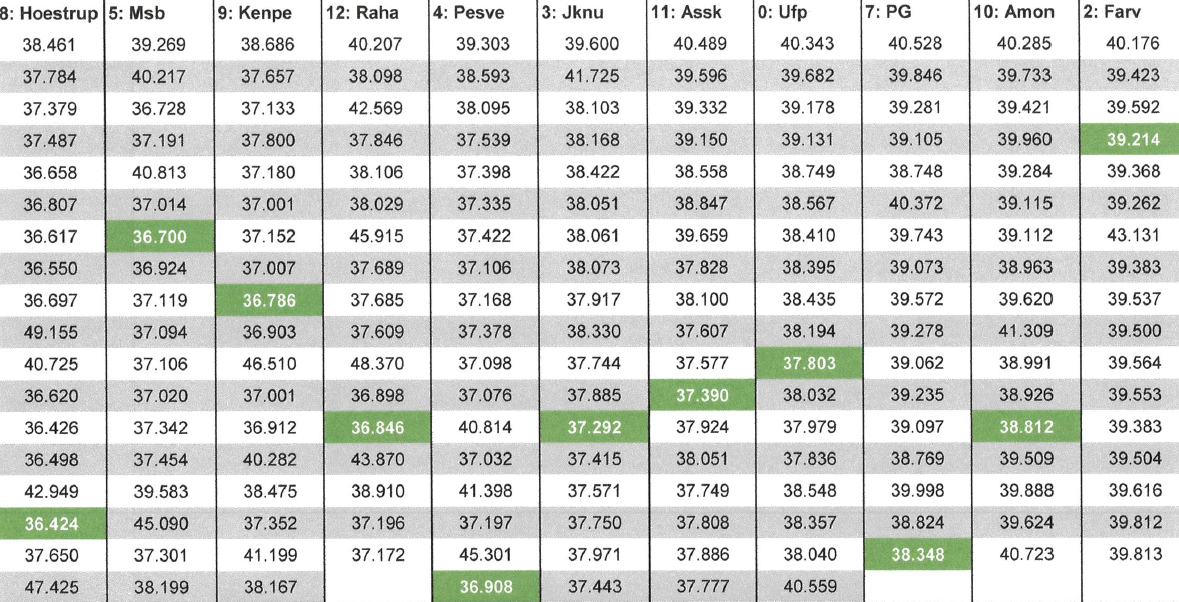

In [11]:
display(heat1_img)

In [12]:
display(heat2_columns)

[[([[0, 9], [69, 9], [69, 29], [0, 29]], '11: Jeci'),
  ([[22, 38], [82, 38], [82, 62], [22, 62]], '44.632'),
  ([[14, 70], [90, 70], [90, 94], [14, 94]], '3.35.159'),
  ([[21, 101], [82, 101], [82, 126], [21, 126]], '37.605'),
  ([[22, 134], [80, 134], [80, 158], [22, 158]], '37.927'),
  ([[22, 166], [82, 166], [82, 190], [22, 190]], '37.384'),
  ([[22, 198], [82, 198], [82, 222], [22, 222]], '37.232'),
  ([[23, 231], [83, 231], [83, 251], [23, 251]], '46.456'),
  ([[23, 263], [83, 263], [83, 283], [23, 283]], '39.858'),
  ([[23, 295], [83, 295], [83, 315], [23, 315]], '37.123'),
  ([[23, 327], [81, 327], [81, 347], [23, 347]], '37.974'),
  ([[23, 359], [83, 359], [83, 379], [23, 379]], '38.822')],
 [([[108, 6], [172, 6], [172, 32], [108, 32]], '3: Djak'),
  ([[131, 39], [189, 39], [189, 59], [131, 59]], '38.444'),
  ([[131, 71], [189, 71], [189, 91], [131, 91]], '41.729'),
  ([[124, 102], [198, 102], [198, 126], [124, 126]], '3.28.820'),
  ([[131, 135], [189, 135], [189, 155], [131, 

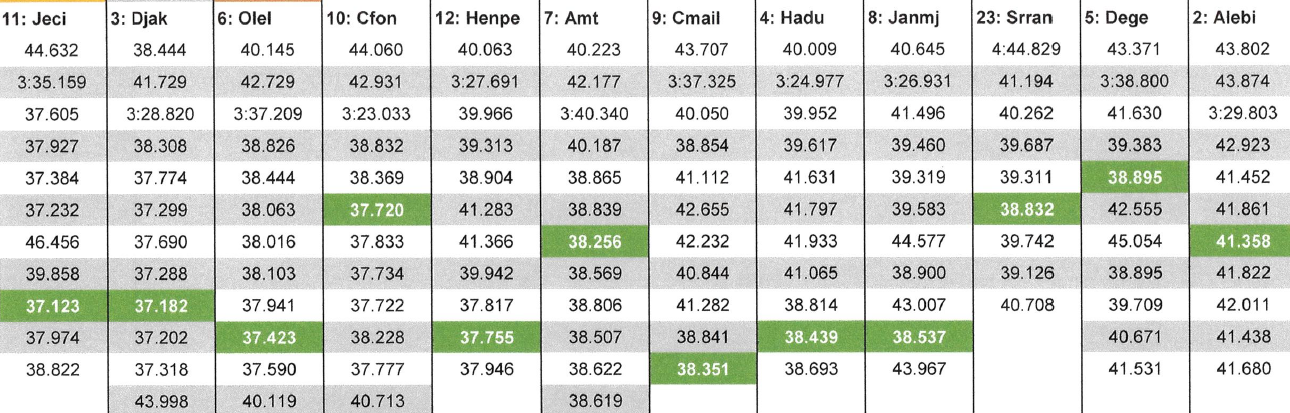

In [13]:
display(heat2_img)

In [14]:
heat3_columns

[[([[0, 1], [101, 1], [101, 21], [0, 21]], '14: Hoestru'),
  ([[21, 33], [81, 33], [81, 53], [21, 53]], '41.510'),
  ([[15, 65], [87, 65], [87, 85], [15, 85]], '3.04.263'),
  ([[23, 97], [81, 97], [81, 117], [23, 117]], '37.875'),
  ([[23, 129], [81, 129], [81, 149], [23, 149]], '37.093'),
  ([[23, 161], [81, 161], [81, 181], [23, 181]], '36.724'),
  ([[23, 193], [79, 193], [79, 213], [23, 213]], '40.331'),
  ([[23, 225], [81, 225], [81, 245], [23, 245]], '36.895'),
  ([[23, 257], [81, 257], [81, 277], [23, 277]], '36.662'),
  ([[23, 289], [81, 289], [81, 309], [23, 309]], '42.319'),
  ([[23, 321], [81, 321], [81, 341], [23, 341]], '38.011'),
  ([[23, 353], [81, 353], [81, 373], [23, 373]], '36.123'),
  ([[23, 385], [83, 385], [83, 405], [23, 405]], '36.105'),
  ([[25, 417], [83, 417], [83, 437], [25, 437]], '36.393'),
  ([[22, 446], [84, 446], [84, 470], [22, 470]], '37.520'),
  ([[25, 479], [83, 479], [83, 499], [25, 499]], '36.439')],
 [([[107, 1], [193, 1], [193, 21], [107, 21]], '

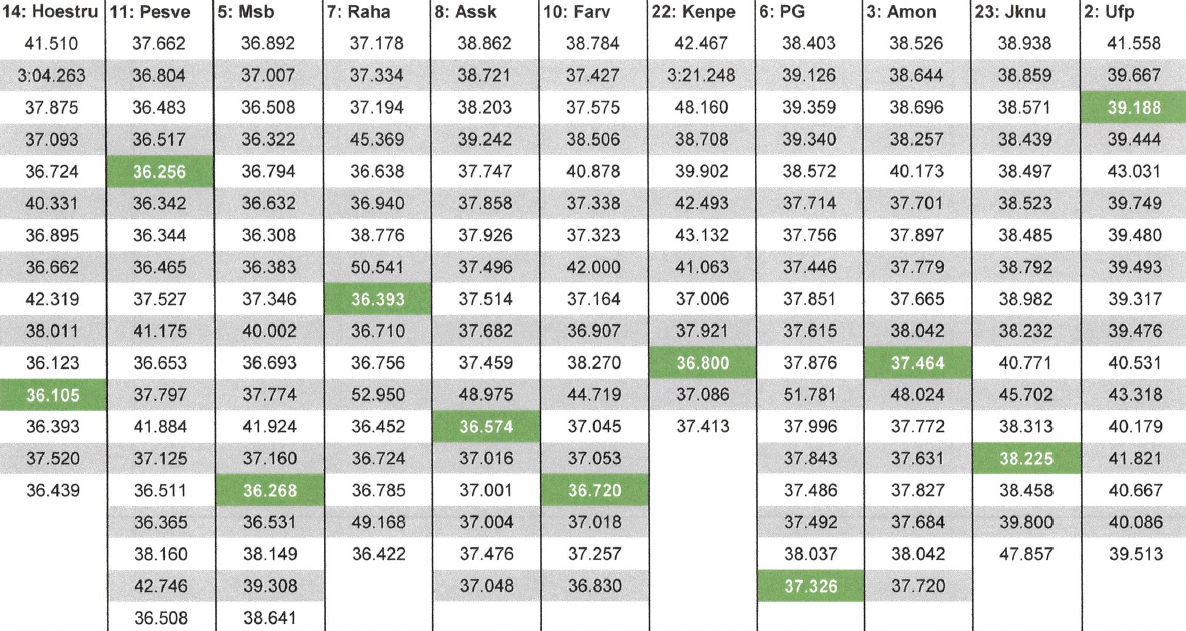

In [15]:
display(heat3_img)

In [16]:
heat4_columns

[[([[1, 3], [77, 3], [77, 23], [1, 23]], '14: Cfon'),
  ([[25, 35], [83, 35], [83, 55], [25, 55]], '41.360'),
  ([[25, 67], [83, 67], [83, 87], [25, 87]], '39.863'),
  ([[24, 96], [84, 96], [84, 120], [24, 120]], '39.460'),
  ([[25, 131], [83, 131], [83, 151], [25, 151]], '38.992'),
  ([[25, 163], [85, 163], [85, 183], [25, 183]], '36.825'),
  ([[25, 195], [83, 195], [83, 215], [25, 215]], '37.974'),
  ([[25, 227], [83, 227], [83, 247], [25, 247]], '39.001'),
  ([[24, 256], [84, 256], [84, 280], [24, 280]], '37.138'),
  ([[24, 288], [86, 288], [86, 312], [24, 312]], '37.505'),
  ([[24, 320], [86, 320], [86, 344], [24, 344]], '37.452'),
  ([[24, 352], [86, 352], [86, 376], [24, 376]], '36.846'),
  ([[25, 385], [85, 385], [85, 405], [25, 405]], '37.736'),
  ([[25, 417], [85, 417], [85, 437], [25, 437]], '37.879'),
  ([[25, 449], [85, 449], [85, 469], [25, 469]], '38.036'),
  ([[25, 481], [83, 481], [83, 501], [25, 501]], '37.007'),
  ([[25, 513], [85, 513], [85, 533], [25, 533]], '36.349

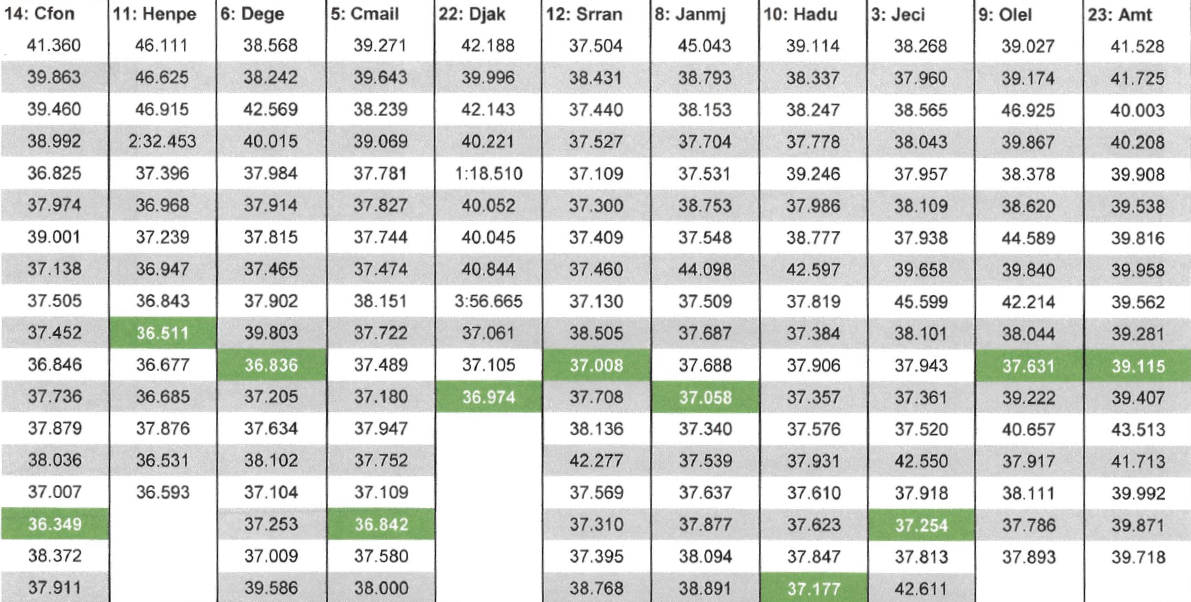

In [17]:
display(heat4_img)

In [18]:

def get_kart_and_driver(column):
    box, text = column[0]
    pattern = r'(\d+): (\S+)'
    match = re.match(pattern, text)
    if match:
        return match.groups()
    
for c in heat4_columns:
    display(get_kart_and_driver(c))


('14', 'Cfon')

('11', 'Henpe')

('6', 'Dege')

('5', 'Cmail')

('22', 'Djak')

('12', 'Srran')

('8', 'Janmj')

('10', 'Hadu')

('3', 'Jeci')

('9', 'Olel')

('23', 'Amt')

In [59]:
def duration_parser(duration_str):
    parts = re.split(r'[. :]', duration_str)
    if len(parts) == 3:
        # The input string has the "minutes.seconds.milliseconds" format
        minutes, seconds, milliseconds = map(int, parts)
    elif len(parts) == 2:
        # The input string has the "seconds.milliseconds" format
        minutes = 0
        seconds, milliseconds = map(int, parts)
    else:
        raise ValueError("Invalid format " + duration_str)

    # Create a timedelta object    
    #print(duration_str, minutes, seconds, milliseconds)
    return timedelta(
        minutes=minutes,
        seconds=seconds, 
        milliseconds=milliseconds)
    

def get_heat_as_table(heat, heat_name):
    rows = []
    for column in heat:
        kart, driver = get_kart_and_driver(column)
        # Correct name
        if driver == 'Hoestru':
            driver = 'Hoestrup'
        for lap_num, (_, time) in enumerate(column[1:], 1):
            parsed_time = duration_parser(time)
            rows.append((heat_name, driver, kart, lap_num, parsed_time))
    return rows,["Heat", "Driver", "Kart", "Lap", "Time"]


heat1_table, header = get_heat_as_table(heat1_columns, "Heat 1")
heat2_table, header = get_heat_as_table(heat2_columns, "Heat 2")
heat3_table, header = get_heat_as_table(heat3_columns, "Heat 3")
heat4_table, header = get_heat_as_table(heat4_columns, "Heat 4")

heat1 = pd.DataFrame(heat1_table, columns=header)
heat2 = pd.DataFrame(heat2_table, columns=header)
heat3 = pd.DataFrame(heat3_table, columns=header)
heat4 = pd.DataFrame(heat4_table, columns=header)


In [60]:

display(heat1)
display(heat2)
display(heat3)
display(heat4)


Heat    Driver Kart  Lap                   Time
0    Heat 1  Hoestrup    8    1 0 days 00:00:38.461000
1    Heat 1  Hoestrup    8    2 0 days 00:00:37.784000
2    Heat 1  Hoestrup    8    3 0 days 00:00:37.379000
3    Heat 1  Hoestrup    8    4 0 days 00:00:37.487000
4    Heat 1  Hoestrup    8    5 0 days 00:00:36.658000
..      ...       ...  ...  ...                    ...
189  Heat 1      Farv    2   13 0 days 00:00:39.383000
190  Heat 1      Farv    2   14 0 days 00:00:39.504000
191  Heat 1      Farv    2   15 0 days 00:00:39.616000
192  Heat 1      Farv    2   16 0 days 00:00:39.812000
193  Heat 1      Farv    2   17 0 days 00:00:39.813000

[194 rows x 5 columns]

Heat Driver Kart  Lap                   Time
0    Heat 2   Jeci   11    1 0 days 00:00:44.632000
1    Heat 2   Jeci   11    2 0 days 00:03:35.159000
2    Heat 2   Jeci   11    3 0 days 00:00:37.605000
3    Heat 2   Jeci   11    4 0 days 00:00:37.927000
4    Heat 2   Jeci   11    5 0 days 00:00:37.384000
..      ...    ...  ...  ...                    ...
129  Heat 2  Alebi    2    7 0 days 00:00:41.358000
130  Heat 2  Alebi    2    8 0 days 00:00:41.822000
131  Heat 2  Alebi    2    9 0 days 00:00:42.011000
132  Heat 2  Alebi    2   10 0 days 00:00:41.438000
133  Heat 2  Alebi    2   11 0 days 00:00:41.680000

[134 rows x 5 columns]

Heat    Driver Kart  Lap                   Time
0    Heat 3  Hoestrup   14    1 0 days 00:00:41.510000
1    Heat 3  Hoestrup   14    2 0 days 00:03:04.263000
2    Heat 3  Hoestrup   14    3 0 days 00:00:37.875000
3    Heat 3  Hoestrup   14    4 0 days 00:00:37.093000
4    Heat 3  Hoestrup   14    5 0 days 00:00:36.724000
..      ...       ...  ...  ...                    ...
184  Heat 3       Ufp   12   13 0 days 00:00:40.179000
185  Heat 3       Ufp   12   14 0 days 00:00:41.821000
186  Heat 3       Ufp   12   15 0 days 00:00:40.667000
187  Heat 3       Ufp   12   16 0 days 00:00:40.086000
188  Heat 3       Ufp   12   17 0 days 00:00:39.513000

[189 rows x 5 columns]

Heat Driver Kart  Lap                   Time
0    Heat 4   Cfon   14    1 0 days 00:00:41.360000
1    Heat 4   Cfon   14    2 0 days 00:00:39.863000
2    Heat 4   Cfon   14    3 0 days 00:00:39.460000
3    Heat 4   Cfon   14    4 0 days 00:00:38.992000
4    Heat 4   Cfon   14    5 0 days 00:00:36.825000
..      ...    ...  ...  ...                    ...
182  Heat 4    Amt   23   13 0 days 00:00:43.513000
183  Heat 4    Amt   23   14 0 days 00:00:41.713000
184  Heat 4    Amt   23   15 0 days 00:00:39.992000
185  Heat 4    Amt   23   16 0 days 00:00:39.871000
186  Heat 4    Amt   23   17 0 days 00:00:39.718000

[187 rows x 5 columns]

In [61]:
display(heat1.describe())
display(heat2.describe())
display(heat3.describe())
display(heat4.describe())

Lap                       Time
count  194.000000                        194
mean     9.324742  0 days 00:00:38.824365979
std      5.107417  0 days 00:00:02.078184055
min      1.000000     0 days 00:00:36.424000
25%      5.000000     0 days 00:00:37.427250
50%      9.000000     0 days 00:00:38.376000
75%     14.000000     0 days 00:00:39.549000
max     18.000000     0 days 00:00:49.155000

Lap                       Time
count  134.00000                        134
mean     6.11194  0 days 00:00:55.907843283
std      3.26904  0 days 00:00:51.423046653
min      1.00000     0 days 00:00:37.123000
25%      3.00000     0 days 00:00:38.444000
50%      6.00000     0 days 00:00:39.900000
75%      9.00000     0 days 00:00:41.851250
max     12.00000     0 days 00:04:44.829000

Lap                       Time
count  189.000000                        189
mean     9.174603  0 days 00:00:40.418523809
std      5.095491  0 days 00:00:16.092825408
min      1.000000     0 days 00:00:36.105000
25%      5.000000     0 days 00:00:37.018000
50%      9.000000     0 days 00:00:37.851000
75%     13.000000     0 days 00:00:39.340000
max     19.000000     0 days 00:03:21.248000

Lap                       Time
count  187.000000                        187
mean     9.096257  0 days 00:00:40.614256684
std      5.053620  0 days 00:00:17.009814402
min      1.000000     0 days 00:00:36.349000
25%      5.000000     0 days 00:00:37.504500
50%      9.000000     0 days 00:00:37.960000
75%     13.000000     0 days 00:00:39.550000
max     18.000000     0 days 00:03:56.665000

In [62]:
heat1.to_csv("./2023-10-11/heat1.csv", index=False)
heat2.to_csv("./2023-10-11/heat2.csv", index=False)
heat3.to_csv("./2023-10-11/heat3.csv", index=False)
heat4.to_csv("./2023-10-11/heat4.csv", index=False)

Some outliers are present in the data, especially when the racing was stopped. So I am removing any laptime greater than 1 minute, to get rid of the most extreme outliers.

In [63]:
def remove_outliers(heat):
    return heat[heat["Time"] < timedelta(minutes=1)]

heat1 = remove_outliers(heat1)
heat2 = remove_outliers(heat2)
heat3 = remove_outliers(heat3)
heat4 = remove_outliers(heat4)

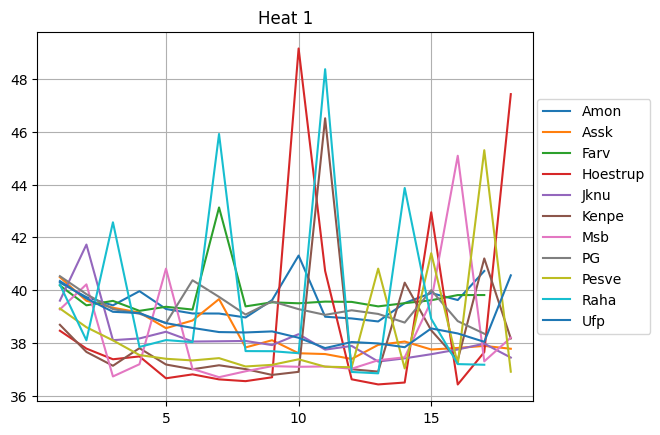

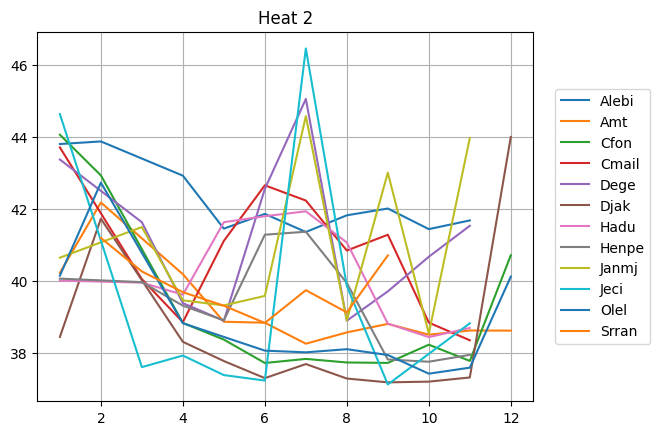

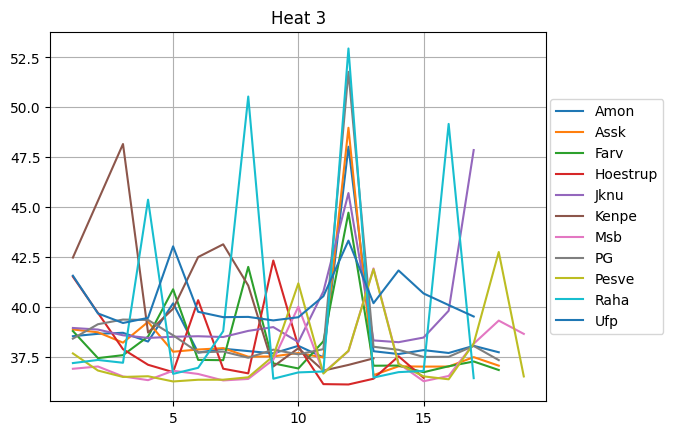

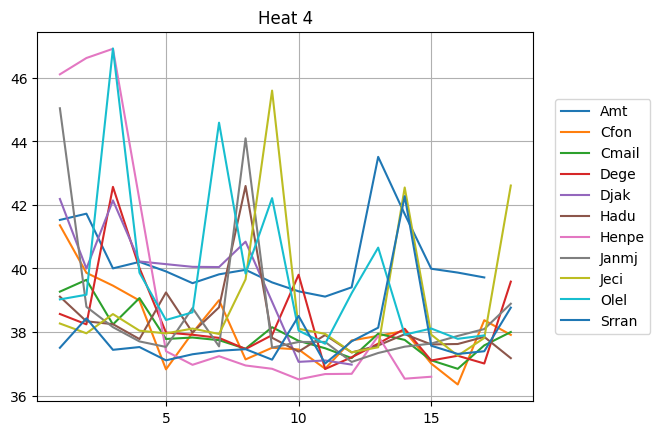

In [67]:
def plot_lap_times(heat):
    for name,g in heat.groupby('Driver'):
        plt.plot(g["Lap"], g['Time'].apply(lambda x: x.total_seconds()), label=name)
    plt.grid(True)
    plt.locator_params(axis="x", integer=True)
    plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.title(heat.iloc[0]["Heat"])
    plt.show()
    
plot_lap_times(heat1)
plot_lap_times(heat2)
plot_lap_times(heat3)
plot_lap_times(heat4)

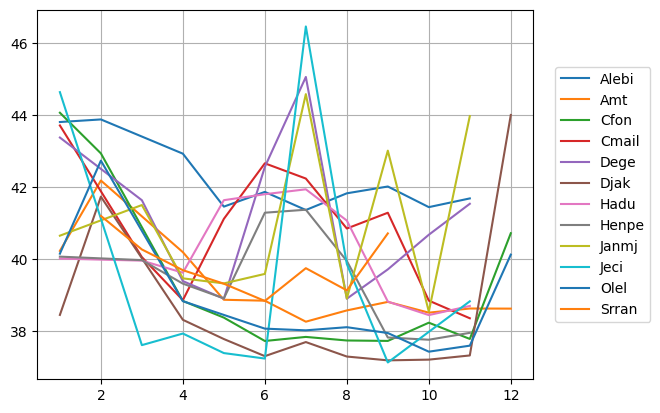

In [26]:
plot_lap_times(heat2)

In [68]:
combined = pd.concat([heat1, heat2, heat3, heat4], ignore_index=True)


Double check that the rows got a new index. By default each row would keep the index it had in the original dataframe. Going forward I will need the order to be fixed so the `ignore_index=True` parameter causes the result dataframe to get a new index. This is desirable as otherwise we would have duplicate index values, which can cause issues later on.

In [70]:
combined.index

RangeIndex(start=0, stop=687, step=1)

Create new laptime columns. Having it as a floating point number of seconds will make the predictions look better.

In [71]:
combined["TimeNs"] = combined["Time"].values.astype(np.int64)
display(combined.iloc[combined["Time"].idxmin()])
combined["TimeS"] = combined["TimeNs"] / 1_000_000_000

Heat                      Heat 3
Driver                  Hoestrup
Kart                          14
Lap                           12
Time      0 days 00:00:36.105000
TimeNs               36105000000
Name: 326, dtype: object

In [72]:
# Fastest lap
combined[combined.Time == combined.Time.min()]

Heat    Driver Kart  Lap                   Time       TimeNs   TimeS
326  Heat 3  Hoestrup   14   12 0 days 00:00:36.105000  36105000000  36.105

In [73]:
# Average lap time for each driver
combined.groupby("Driver").mean(numeric_only=True).sort_values(by="TimeNs", inplace=False)

Lap        TimeNs      TimeS
Driver                                     
Msb       9.756757  3.785962e+10  37.859622
Pesve     9.756757  3.798608e+10  37.986081
Assk      9.500000  3.836478e+10  38.364778
Hoestrup  9.031250  3.838475e+10  38.384750
Srran     8.269231  3.849415e+10  38.494154
Cfon      8.482759  3.853879e+10  38.538793
Hadu      8.392857  3.893793e+10  38.937929
Jknu      9.257143  3.894186e+10  38.941857
Cmail     8.392857  3.895529e+10  38.955286
Farv      9.257143  3.898986e+10  38.989857
Kenpe     8.666667  3.904513e+10  39.045133
PG        9.257143  3.908280e+10  39.082800
Djak      6.619048  3.908862e+10  39.088619
Amon      9.257143  3.910911e+10  39.109114
Jeci      8.392857  3.914932e+10  39.149321
Henpe     7.500000  3.917800e+10  39.178000
Dege      8.392857  3.931071e+10  39.310714
Olel      8.142857  3.940336e+10  39.403357
Janmj     8.392857  3.944407e+10  39.444071
Ufp       9.257143  3.950731e+10  39.507314
Raha      9.000000  3.974544e+10  39.745441
Amt       8.142857  3.987593e+10  39.875929
Alebi     6.300000  4.222210e+10  42.222100

In [74]:
# Median laptime for each driver
combined.groupby("Driver").median(numeric_only=True).sort_values(by="TimeNs", inplace=False)

Lap        TimeNs    TimeS
Driver                               
Hoestrup   9.0  3.699400e+10  36.9940
Msb       10.0  3.711900e+10  37.1190
Pesve     10.0  3.719700e+10  37.1970
Raha       9.0  3.764700e+10  37.6470
Kenpe      8.5  3.772850e+10  37.7285
Assk       9.5  3.784300e+10  37.8430
Henpe      7.5  3.784650e+10  37.8465
Cfon       8.0  3.791100e+10  37.9110
Srran      7.5  3.792200e+10  37.9220
Jeci       8.0  3.796700e+10  37.9670
Cmail      8.0  3.819500e+10  38.1950
Djak       7.0  3.830800e+10  38.3080
Jknu       9.0  3.833000e+10  38.3300
Hadu       8.0  3.838800e+10  38.3880
Olel       8.0  3.853200e+10  38.5320
Janmj      8.0  3.864500e+10  38.6450
Dege       8.0  3.873150e+10  38.7315
PG         9.0  3.882400e+10  38.8240
Amon       9.0  3.892600e+10  38.9260
Farv       9.0  3.936800e+10  39.3680
Ufp        9.0  3.944400e+10  39.4440
Amt        8.0  3.976700e+10  39.7670
Alebi      6.5  4.184150e+10  41.8415

In [35]:
# Average laptime for each kart
combined.groupby("Kart").mean(numeric_only=True).sort_values(by="TimeNs", inplace=False)

Lap        TimeNs      TimeS
Kart                                   
14    9.031250  3.799081e+10  37.990812
5     9.169231  3.838954e+10  38.389538
11    8.868852  3.848495e+10  38.484951
3     9.046154  3.859177e+10  38.591769
6     8.872340  3.862604e+10  38.626043
0     9.500000  3.867989e+10  38.679889
10    8.906250  3.878625e+10  38.786250
8     9.015625  3.894609e+10  38.946094
4     8.392857  3.900396e+10  39.003964
12    8.725806  3.928829e+10  39.288290
9     8.622222  3.940058e+10  39.400578
7     8.466667  3.953064e+10  39.530644
22    6.954545  3.994455e+10  39.944545
23    8.333333  3.998005e+10  39.980048
2     8.000000  4.066859e+10  40.668593

In [36]:
# Mean laptime for each kart
combined.groupby("Kart").median(numeric_only=True).sort_values(by="TimeNs", inplace=False)

Lap        TimeNs    TimeS
Kart                            
14    9.0  3.762800e+10  37.6280
11    9.0  3.766200e+10  37.6620
8     9.0  3.772550e+10  37.7255
5     9.0  3.774400e+10  37.7440
3     9.0  3.795700e+10  37.9570
6     9.0  3.798400e+10  37.9840
10    9.0  3.830350e+10  38.3035
0     9.5  3.842250e+10  38.4225
4     8.0  3.851600e+10  38.5160
9     8.0  3.862000e+10  38.6200
7     8.0  3.882400e+10  38.8240
12    8.5  3.883600e+10  38.8360
23    8.0  3.962450e+10  39.6245
2     8.0  3.981200e+10  39.8120
22    7.0  4.002050e+10  40.0205

In [37]:
combined.index


RangeIndex(start=0, stop=687, step=1)

In [38]:
combined.describe()

Lap                       Time        TimeNs       TimeS
count  687.000000                        687  6.870000e+02  687.000000
mean     8.752547  0 days 00:00:38.994889374  3.899489e+10   38.994889
std      4.906403  0 days 00:00:02.391981247  2.391981e+09    2.391981
min      1.000000     0 days 00:00:36.105000  3.610500e+10   36.105000
25%      5.000000     0 days 00:00:37.464500  3.746450e+10   37.464500
50%      8.000000     0 days 00:00:38.242000  3.824200e+10   38.242000
75%     13.000000     0 days 00:00:39.713500  3.971350e+10   39.713500
max     19.000000     0 days 00:00:52.950000  5.295000e+10   52.950000

Now for the fun stuff! Lets apply a linear model to pedict laptimes. By looking at the coefficients of the model, we can then see which karts the model thinks are fast and which are slow.

First we need to encode the data so the model can work with it. We are using two featues. Driver and kart. Both features are categorical. A common way to encode categorical features is to use a "one hot" encoding. With one hot each category gets their own input parameter.

In [39]:
# Encode the input to the model, the kart and the driver
feature_encoder = OneHotEncoder()
features = feature_encoder.fit_transform(combined[["Kart","Driver"]]).toarray()
feature_encoder.categories_

[array(['0', '10', '11', '12', '14', '2', '22', '23', '3', '4', '5', '6',
        '7', '8', '9'], dtype=object),
 array(['Alebi', 'Amon', 'Amt', 'Assk', 'Cfon', 'Cmail', 'Dege', 'Djak',
        'Farv', 'Hadu', 'Henpe', 'Hoestrup', 'Janmj', 'Jeci', 'Jknu',
        'Kenpe', 'Msb', 'Olel', 'PG', 'Pesve', 'Raha', 'Srran', 'Ufp'],
       dtype=object)]

In [40]:

feature_labels = []
for labels in feature_encoder.categories_:
    for cat in labels:
        feature_labels.append(cat)
        

In [41]:

features_pd = pd.DataFrame(features, columns=feature_labels)
features_pd

0   10   11   12   14    2   22   23    3    4  ...  Jeci  Jknu  Kenpe  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0    0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0    0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0    0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0    0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0    0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...    ...   
682  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0    0.0   
683  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0    0.0   
684  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0    0.0   
685  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0    0.0   
686  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0    0.0   

     Msb  Olel   PG  Pesve  Raha  Srran  Ufp  
0    0.0   0.0  0.0    0.0   0.0    0.0  0.0  
1    0.0   0.0  0.0    0.0   0.0    0.0  0.0  
2    0.0   0.0  0.0    0.0   0.0    0.0  0.0  
3    0.0   0.0  0.0    0.0   0.0    0.0  0.0  
4    0.0   0.0  0.0    0.0   0.0    0.0  0.0  
..   ...   ...  ...    ...   ...    ...  ...  
682  0.0   0.0  0.0    0.0   0.0    0.0  0.0  
683  0.0   0.0  0.0    0.0   0.0    0.0  0.0  
684  0.0   0.0  0.0    0.0   0.0    0.0  0.0  
685  0.0   0.0  0.0    0.0   0.0    0.0  0.0  
686  0.0   0.0  0.0    0.0   0.0    0.0  0.0  

[687 rows x 38 columns]

Now we have our input data in the `features_pd` dataframe. Lets add it to the other data in a combined dataframe

In [75]:
dataset = pd.concat([combined, features_pd], axis=1)
dataset

Heat    Driver Kart  Lap                   Time       TimeNs   TimeS  \
0    Heat 1  Hoestrup    8    1 0 days 00:00:38.461000  38461000000  38.461   
1    Heat 1  Hoestrup    8    2 0 days 00:00:37.784000  37784000000  37.784   
2    Heat 1  Hoestrup    8    3 0 days 00:00:37.379000  37379000000  37.379   
3    Heat 1  Hoestrup    8    4 0 days 00:00:37.487000  37487000000  37.487   
4    Heat 1  Hoestrup    8    5 0 days 00:00:36.658000  36658000000  36.658   
..      ...       ...  ...  ...                    ...          ...     ...   
682  Heat 4       Amt   23   13 0 days 00:00:43.513000  43513000000  43.513   
683  Heat 4       Amt   23   14 0 days 00:00:41.713000  41713000000  41.713   
684  Heat 4       Amt   23   15 0 days 00:00:39.992000  39992000000  39.992   
685  Heat 4       Amt   23   16 0 days 00:00:39.871000  39871000000  39.871   
686  Heat 4       Amt   23   17 0 days 00:00:39.718000  39718000000  39.718   

       0   10   11  ...  Jeci  Jknu  Kenpe  Msb  Olel   PG  Pesve  Raha  \
0    0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
1    0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
2    0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
3    0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
4    0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
..   ...  ...  ...  ...   ...   ...    ...  ...   ...  ...    ...   ...   
682  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
683  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
684  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
685  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   
686  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0   

     Srran  Ufp  
0      0.0  0.0  
1      0.0  0.0  
2      0.0  0.0  
3      0.0  0.0  
4      0.0  0.0  
..     ...  ...  
682    0.0  0.0  
683    0.0  0.0  
684    0.0  0.0  
685    0.0  0.0  
686    0.0  0.0  

[687 rows x 45 columns]

In [43]:
# Spot check that the features line up with the data
dataset.iloc[100]

Heat                        Heat 1
Driver                        Jknu
Kart                             3
Lap                             12
Time        0 days 00:00:37.885000
TimeNs                 37885000000
TimeS                       37.885
0                              0.0
10                             0.0
11                             0.0
12                             0.0
14                             0.0
2                              0.0
22                             0.0
23                             0.0
3                              1.0
4                              0.0
5                              0.0
6                              0.0
7                              0.0
8                              0.0
9                              0.0
Alebi                          0.0
Amon                           0.0
Amt                            0.0
Assk                           0.0
Cfon                           0.0
Cmail                          0.0
Dege                

In the spot check above it is easy to see how the one-hot encoding works

In [44]:
# Now fit the model
#model = linear_model.LinearRegression()
model = linear_model.Ridge(alpha=.5)
true_values = dataset[['TimeS']]
display(true_values)
model.fit(features_pd, true_values)

TimeS
0    38.461
1    37.784
2    37.379
3    37.487
4    36.658
..      ...
682  43.513
683  41.713
684  39.992
685  39.871
686  39.718

[687 rows x 1 columns]

Ridge(alpha=0.5)

I initially used a simple Linear regression. The resulting coefficients were very large and the difference between them were small. It made interpreting the results hard. I switched to the Ridge model. The ridge model penalizes large coefficients, and should therefore avoid the problem with large coefficients.

In [45]:
display(features_pd.columns)

coefs = pd.DataFrame(model.coef_, columns=features_pd.columns).T
coefs

Index(['0', '10', '11', '12', '14', '2', '22', '23', '3', '4', '5', '6', '7',
       '8', '9', 'Alebi', 'Amon', 'Amt', 'Assk', 'Cfon', 'Cmail', 'Dege',
       'Djak', 'Farv', 'Hadu', 'Henpe', 'Hoestrup', 'Janmj', 'Jeci', 'Jknu',
       'Kenpe', 'Msb', 'Olel', 'PG', 'Pesve', 'Raha', 'Srran', 'Ufp'],
      dtype='object')

0
0        -1.814295
10       -0.037087
11       -0.011243
12       -0.256248
14       -1.090932
2         1.436182
22        1.564867
23        1.124506
3        -0.458177
4         1.121557
5        -0.400327
6        -1.328532
7        -0.233225
8        -0.119653
9         0.502609
Alebi     1.580693
Amon      0.233239
Amt       0.155843
Assk     -0.686431
Cfon      0.102041
Cmail    -0.091423
Dege      1.160824
Djak     -0.530127
Farv     -0.803358
Hadu     -0.555065
Henpe     0.161768
Hoestrup -0.193825
Janmj     0.429858
Jeci      0.316045
Jknu     -0.487918
Kenpe    -0.992036
Msb      -0.854692
Olel      0.485268
PG        0.742527
Pesve    -1.657559
Raha      0.851466
Srran    -0.785530
Ufp       1.418390

In [46]:
display(dataset.iloc[0:10])
model.predict(features_pd.iloc[0:10])

Heat    Driver Kart  Lap                   Time       TimeNs   TimeS  \
0  Heat 1  Hoestrup    8    1 0 days 00:00:38.461000  38461000000  38.461   
1  Heat 1  Hoestrup    8    2 0 days 00:00:37.784000  37784000000  37.784   
2  Heat 1  Hoestrup    8    3 0 days 00:00:37.379000  37379000000  37.379   
3  Heat 1  Hoestrup    8    4 0 days 00:00:37.487000  37487000000  37.487   
4  Heat 1  Hoestrup    8    5 0 days 00:00:36.658000  36658000000  36.658   
5  Heat 1  Hoestrup    8    6 0 days 00:00:36.807000  36807000000  36.807   
6  Heat 1  Hoestrup    8    7 0 days 00:00:36.617000  36617000000  36.617   
7  Heat 1  Hoestrup    8    8 0 days 00:00:36.550000  36550000000  36.550   
8  Heat 1  Hoestrup    8    9 0 days 00:00:36.697000  36697000000  36.697   
9  Heat 1  Hoestrup    8   10 0 days 00:00:49.155000  49155000000  49.155   

     0   10   11  ...  Jeci  Jknu  Kenpe  Msb  Olel   PG  Pesve  Raha  Srran  \
0  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
1  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
2  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
3  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
4  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
5  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
6  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
7  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
8  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   
9  0.0  0.0  0.0  ...   0.0   0.0    0.0  0.0   0.0  0.0    0.0   0.0    0.0   

   Ufp  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  
5  0.0  
6  0.0  
7  0.0  
8  0.0  
9  0.0  

[10 rows x 45 columns]

array([[38.81271314],
       [38.81271314],
       [38.81271314],
       [38.81271314],
       [38.81271314],
       [38.81271314],
       [38.81271314],
       [38.81271314],
       [38.81271314],
       [38.81271314]])

In [47]:
predictions = model.predict(features_pd)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(true_values, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(true_values, predictions))


Mean squared error: 4.97
Coefficient of determination: 0.13


As we can see from these values, the model is not a very good fit, so any conclusions should not be taken very seriously

In [54]:
combined["Predicted Time"] = predictions
combined["Error"] = combined["Predicted Time"] - combined["TimeS"]
combined

Heat    Driver Kart  Lap                   Time       TimeNs   TimeS  \
0    Heat 1  Hoestrup    8    1 0 days 00:00:38.461000  38461000000  38.461   
1    Heat 1  Hoestrup    8    2 0 days 00:00:37.784000  37784000000  37.784   
2    Heat 1  Hoestrup    8    3 0 days 00:00:37.379000  37379000000  37.379   
3    Heat 1  Hoestrup    8    4 0 days 00:00:37.487000  37487000000  37.487   
4    Heat 1  Hoestrup    8    5 0 days 00:00:36.658000  36658000000  36.658   
..      ...       ...  ...  ...                    ...          ...     ...   
682  Heat 4       Amt   23   13 0 days 00:00:43.513000  43513000000  43.513   
683  Heat 4       Amt   23   14 0 days 00:00:41.713000  41713000000  41.713   
684  Heat 4       Amt   23   15 0 days 00:00:39.992000  39992000000  39.992   
685  Heat 4       Amt   23   16 0 days 00:00:39.871000  39871000000  39.871   
686  Heat 4       Amt   23   17 0 days 00:00:39.718000  39718000000  39.718   

     Predicted Time     Error  
0         38.812713  0.351713  
1         38.812713  1.028713  
2         38.812713  1.433713  
3         38.812713  1.325713  
4         38.812713  2.154713  
..              ...       ...  
682       40.406540 -3.106460  
683       40.406540 -1.306460  
684       40.406540  0.414540  
685       40.406540  0.535540  
686       40.406540  0.688540  

[687 rows x 9 columns]

Lets pick the driver and kart coefficients and plot them! Well see which karts are slow and which drivers are the best! :D The concrete values can be interpreted as how the time changes from the baseline, given a specific kart or driver. A negative value indicates the kart or dricer is faster than base, and positive indicates slower.

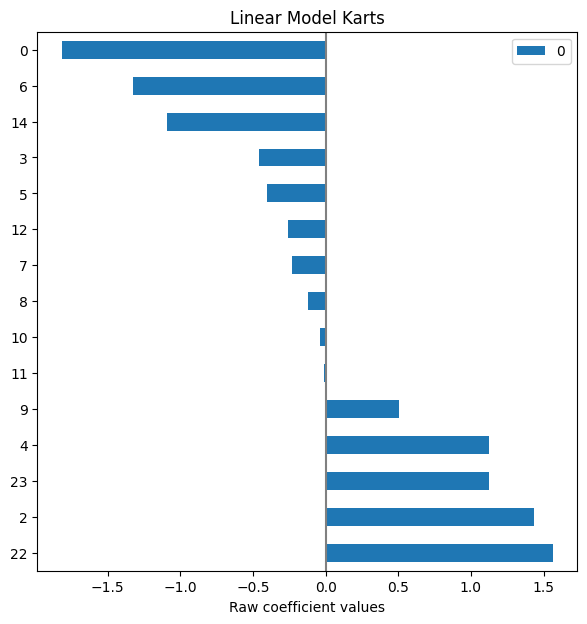

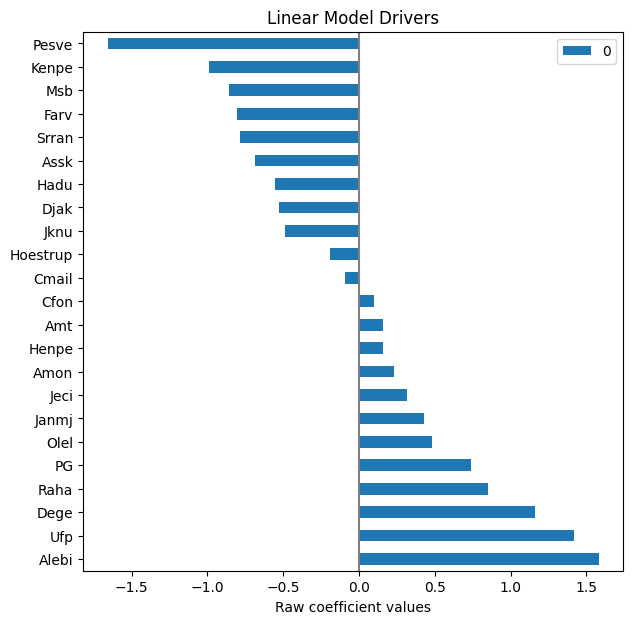

In [55]:
carts_coefs = coefs.iloc[0:len(feature_encoder.categories_[0])]
carts_coefs = carts_coefs.sort_values(ascending=False, by=0)

driver_coefs = coefs.iloc[len(feature_encoder.categories_[0]):]
driver_coefs = driver_coefs.sort_values(ascending=False, by=0)


carts_coefs.plot.barh(figsize=(9, 7))
plt.title("Linear Model Karts")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
plt.show()

driver_coefs.plot.barh(figsize=(9, 7))
plt.title("Linear Model Drivers")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
plt.show()

In [77]:
# Difference between fastest kart, #0, and slowest, #22
carts_coefs.loc["0"] - carts_coefs.loc["22"] 

0   -3.379162
dtype: float64

In [51]:
# The bias, can be considered the neutral lap time in seconds
model.intercept_

array([39.12619082])

Now the model is mot very accurate. I wonder what would happen if I just used the best lap for each driver in each heat

In [82]:
best_idx = combined.groupby(["Heat", "Driver"])["TimeNs"].idxmin()
best_only = combined.loc[best_idx]
best_only


Heat    Driver Kart  Lap                   Time       TimeNs   TimeS
172  Heat 1      Amon   10   13 0 days 00:00:38.812000  38812000000  38.812
118  Heat 1      Assk   11   12 0 days 00:00:37.390000  37390000000  37.390
180  Heat 1      Farv    2    4 0 days 00:00:39.214000  39214000000  39.214
15   Heat 1  Hoestrup    8   16 0 days 00:00:36.424000  36424000000  36.424
101  Heat 1      Jknu    3   13 0 days 00:00:37.292000  37292000000  37.292
44   Heat 1     Kenpe    9    9 0 days 00:00:36.786000  36786000000  36.786
24   Heat 1       Msb    5    7 0 days 00:00:36.700000  36700000000  36.700
159  Heat 1        PG    7   17 0 days 00:00:38.348000  38348000000  38.348
88   Heat 1     Pesve    4   18 0 days 00:00:36.908000  36908000000  36.908
66   Heat 1      Raha   12   13 0 days 00:00:36.846000  36846000000  36.846
135  Heat 1       Ufp    0   11 0 days 00:00:37.803000  37803000000  37.803
311  Heat 2     Alebi    2    7 0 days 00:00:41.358000  41358000000  41.358
252  Heat 2       Amt    7    7 0 days 00:00:38.256000  38256000000  38.256
230  Heat 2      Cfon   10    6 0 days 00:00:37.720000  37720000000  37.720
267  Heat 2     Cmail    9   11 0 days 00:00:38.351000  38351000000  38.351
299  Heat 2      Dege    5    5 0 days 00:00:38.895000  38895000000  38.895
211  Heat 2      Djak    3    9 0 days 00:00:37.182000  37182000000  37.182
276  Heat 2      Hadu    4   10 0 days 00:00:38.439000  38439000000  38.439
245  Heat 2     Henpe   12   10 0 days 00:00:37.755000  37755000000  37.755
286  Heat 2     Janmj    8   10 0 days 00:00:38.537000  38537000000  38.537
201  Heat 2      Jeci   11    9 0 days 00:00:37.123000  37123000000  37.123
223  Heat 2      Olel    6   10 0 days 00:00:37.423000  37423000000  37.423
292  Heat 2     Srran   23    6 0 days 00:00:38.832000  38832000000  38.832
461  Heat 3      Amon    3   11 0 days 00:00:37.464000  37464000000  37.464
397  Heat 3      Assk    8   13 0 days 00:00:36.574000  36574000000  36.574
417  Heat 3      Farv   10   15 0 days 00:00:36.720000  36720000000  36.720
326  Heat 3  Hoestrup   14   12 0 days 00:00:36.105000  36105000000  36.105
482  Heat 3      Jknu   23   14 0 days 00:00:38.225000  38225000000  38.225
430  Heat 3     Kenpe   22   11 0 days 00:00:36.800000  36800000000  36.800
363  Heat 3       Msb    5   15 0 days 00:00:36.268000  36268000000  36.268
450  Heat 3        PG    6   18 0 days 00:00:37.326000  37326000000  37.326
334  Heat 3     Pesve   11    5 0 days 00:00:36.256000  36256000000  36.256
376  Heat 3      Raha    7    9 0 days 00:00:36.393000  36393000000  36.393
488  Heat 3       Ufp   12    3 0 days 00:00:39.188000  39188000000  39.188
680  Heat 4       Amt   23   11 0 days 00:00:39.115000  39115000000  39.115
518  Heat 4      Cfon   14   16 0 days 00:00:36.349000  36349000000  36.349
568  Heat 4     Cmail    5   16 0 days 00:00:36.842000  36842000000  36.842
545  Heat 4      Dege    6   11 0 days 00:00:36.836000  36836000000  36.836
580  Heat 4      Djak   22   12 0 days 00:00:36.974000  36974000000  36.974
634  Heat 4      Hadu   10   18 0 days 00:00:37.177000  37177000000  37.177
529  Heat 4     Henpe   11   10 0 days 00:00:36.511000  36511000000  36.511
610  Heat 4     Janmj    8   12 0 days 00:00:37.058000  37058000000  37.058
650  Heat 4      Jeci    3   16 0 days 00:00:37.254000  37254000000  37.254
663  Heat 4      Olel    9   11 0 days 00:00:37.631000  37631000000  37.631
591  Heat 4     Srran   12   11 0 days 00:00:37.008000  37008000000  37.008

In [87]:
best_only_features = feature_encoder.transform(best_only[["Kart", "Driver"]]).toarray()
best_only_features
best_only_model = linear_model.Ridge()
best_only_model.fit(best_only_features, best_only[["TimeS"]])


Ridge()

In [89]:
best_only_predictions = best_only_model.predict(best_only_features)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(best_only[["TimeS"]], best_only_predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(best_only[["TimeS"]], best_only_predictions))

Mean squared error: 0.23
Coefficient of determination: 0.79


This model is much more accurate!

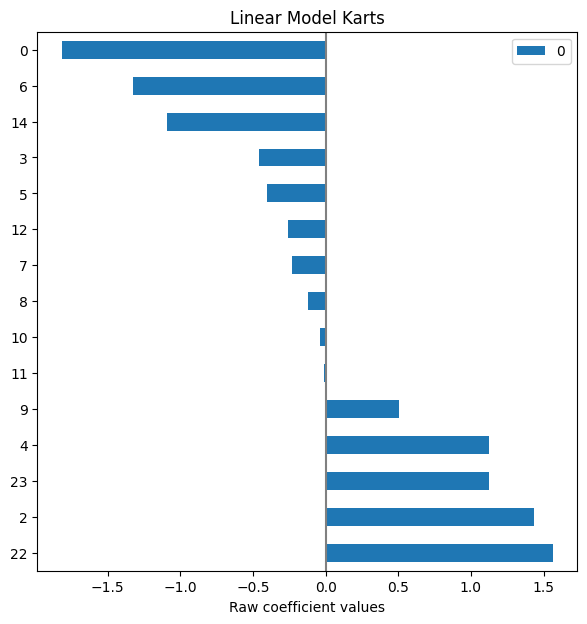

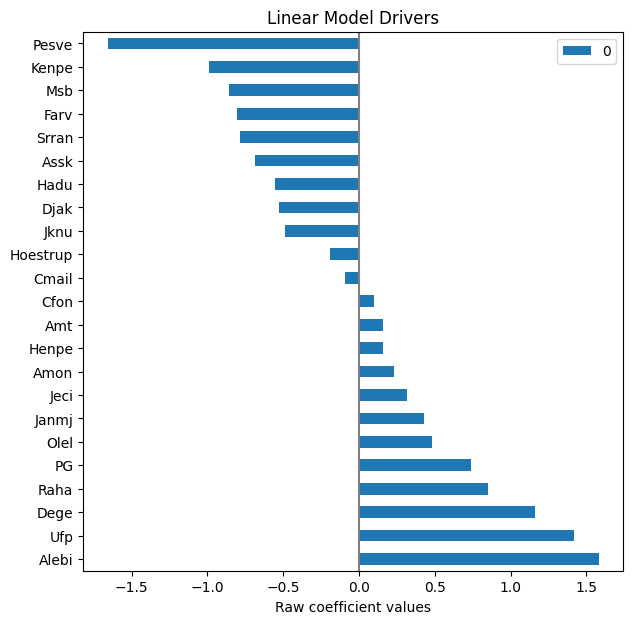

In [91]:
best_coefs = pd.DataFrame(best_only_model.coef_, columns=features_pd.columns).T

best_carts_coefs = coefs.iloc[0:len(feature_encoder.categories_[0])]
best_carts_coefs = carts_coefs.sort_values(ascending=False, by=0)

best_driver_coefs = coefs.iloc[len(feature_encoder.categories_[0]):]
best_driver_coefs = driver_coefs.sort_values(ascending=False, by=0)


best_carts_coefs.plot.barh(figsize=(9, 7))
plt.title("Linear Model Karts")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
plt.show()

best_driver_coefs.plot.barh(figsize=(9, 7))
plt.title("Linear Model Drivers")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
plt.show()


In [93]:
# The bias, can be considered the neutral lap time in seconds
best_only_model.intercept_

array([37.57919023])